In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from skimage.util import random_noise

## Create MNIST Dataset with Noise  

In [2]:
# Load MNIST dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create noisy dataset
train_data_noisy = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data_noisy = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


100%|██████████| 9912422/9912422 [00:03<00:00, 2933886.62it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 129973920.41it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2752166.39it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10525154.02it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Adding Noise to Dataset and Creating Dataloader

In [3]:
def add_gaussian_noise(image, mean=0, sigma=97):
    """Add Gaussian noise to an image.
    
    Args:
        image: a torch tensor with shape (N, H, W)
        sigma: a float number indicating the standard deviation of Gaussian distribution
    
    Returns:
        a torch tensor with shape (N, H, W)
    """
    noise = torch.randn(image.size()) * sigma 
    noisy_image = image + noise 
    noisy_image = torch.clamp(noisy_image, 0.0, 255.0)

    return noisy_image

# Add Gaussian noise to the dataset
train_data_noisy.data = add_gaussian_noise(train_data_noisy.data, 97)
test_data_noisy.data = add_gaussian_noise(test_data_noisy.data, 97)

# Convert (N, H, W) to (N, C, H, W)
train_data.data = train_data.data.unsqueeze(1)
test_data.data = test_data.data.unsqueeze(1)
train_data_noisy.data = train_data_noisy.data.unsqueeze(1)
test_data_noisy.data = test_data_noisy.data.unsqueeze(1)


### Display Images with Noise

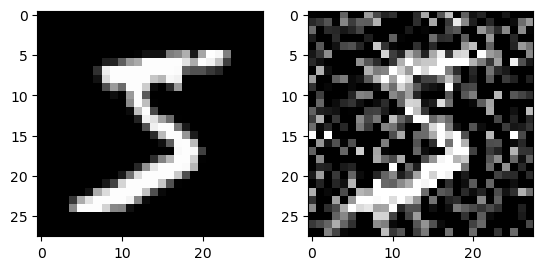

In [4]:
### Display some images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_data.data[0].view(28,28), cmap='gray')
ax[1].imshow(train_data_noisy.data[0].view(28,28), cmap='gray')
plt.show()


### Normalize between 0 and 1

In [5]:
# Normalize the data
train_data.data = train_data.data.float() / 255
test_data.data = test_data.data.float() / 255
train_data_noisy.data = train_data_noisy.data.float() / 255
test_data_noisy.data = test_data_noisy.data.float() / 255

### Creating Train and Test Dataloader

In [6]:
class Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

# Create Dataset
train_dataset = Dataset(train_data_noisy.data, train_data.data)
test_dataset = Dataset(test_data_noisy.data, test_data.data)

# Create DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Create Denoising Autoencoder


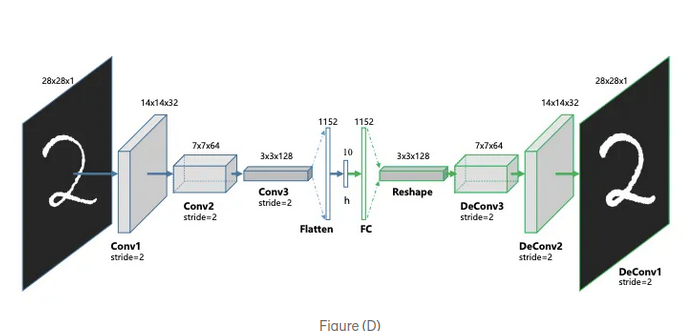

### Create Convolutional Encoder and Decoder for Autoencoder

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)   # 14x14x32
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 7x7x64
        self.conv3 = nn.Conv2d(64, 128, 3,stride=2)             # 3x3x128
        self.fc = nn.Linear(3*3*128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        self.features = F.relu(self.conv3(x))
        x = self.features.view(-1, 3*3*128)
        x = self.fc(x)

        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(10, 3*3*128)
        self.conv1 = nn.ConvTranspose2d(128, 64, 3, stride=2)   # 7x7x64
        self.conv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)  # 14x14x32
        self.conv3 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)  # 28x28x1

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 3, 3)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))

        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x
    


### Training loop

In [8]:
### Training
# Hyperparameters
epochs = 10
lr = 0.002

# Create model
model = Autoencoder()
# Define loss function
criterion = nn.MSELoss()
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# Train model
# Save Input, Output , Reconstructions for every epoch

output_img = []

for epoch in range(epochs):
    # Train
    train_loss = 0
    for _, (X,y) in enumerate(train_loader):
        # Zero gradients
        optimizer.zero_grad()

        # X : (batch_size, 28, 28)
        # y : (batch_size, 28, 28)
        output = model(X)
        # print("output: ",output.dtype)
        # print("y: ",y.shape)
        # print("output: ",output.shape)
        y = y.float()
        # Calculate loss
        loss = criterion(output, y)
        # Backward pass
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # Save Input, Output , Reconstructions for every epoch
        if epoch == epochs-1:
            output_img.append((X, output, y))


    
    # Update train loss
    train_loss /= len(train_loader)
    # Print train loss
    print('Epoch: {} \tTrain Loss: {:.6f}'.format(epoch, train_loss))
    # Save Input, Output , Reconstructions for every epoch
    



Epoch: 0 	Train Loss: 0.035080
Epoch: 1 	Train Loss: 0.020104
Epoch: 2 	Train Loss: 0.018673
Epoch: 3 	Train Loss: 0.017990
Epoch: 4 	Train Loss: 0.017610
Epoch: 5 	Train Loss: 0.017329
Epoch: 6 	Train Loss: 0.017098
Epoch: 7 	Train Loss: 0.016913
Epoch: 8 	Train Loss: 0.016768
Epoch: 9 	Train Loss: 0.016638


### Show single Output

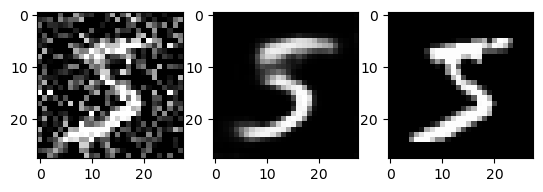

In [9]:
input = output_img[0][0].reshape(-1,28,28).detach().numpy().shape
recons = output_img[0][1].reshape(-1,28,28).detach().numpy().shape
output = output_img[0][2].reshape(-1,28,28).detach().numpy().shape


# Denormalize data

test1 = output_img[0][0][0].reshape(28,28).detach().numpy()
test2 = output_img[0][1][0].reshape(28,28).detach().numpy()
test3 = output_img[0][2][0].reshape(28,28).detach().numpy()

test1 = test1*255
test2 = test2*255
test3 = test3*255

test1 = test1.astype(np.uint8)
test2 = test2.astype(np.uint8)
test3 = test3.astype(np.uint8)

test1 = test1.clip(0,255)
test2 = test2.clip(0,255)
test3 = test3.clip(0,255)


fig, ax = plt.subplots(1, 3)
ax[0].imshow(test1, cmap='gray')
ax[1].imshow(test2, cmap='gray')
ax[2].imshow(test3, cmap='gray')
plt.show()



### 10 instances from Train set

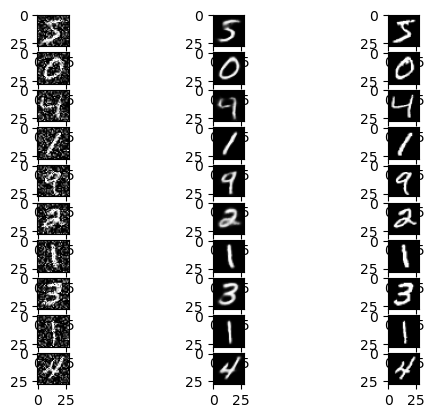

<Figure size 1000x1000 with 0 Axes>

In [10]:
# Display 10 instances of input, reconstruction and output from the train set
fig, ax = plt.subplots(10, 3)
fig = plt.figure(figsize=(10,10))
for i in range(10):
    ax[i][0].imshow(output_img[0][0][i].reshape(28,28).detach().numpy(), cmap='gray')
    ax[i][1].imshow(output_img[0][1][i].reshape(28,28).detach().numpy(), cmap='gray')
    ax[i][2].imshow(output_img[0][2][i].reshape(28,28).detach().numpy(), cmap='gray')


### Evaluation

In [12]:
### Testing
# Test model

outputs = []

with torch.no_grad():
    for _, (X,y) in enumerate(test_loader):
        # X : (batch_size, 28, 28)
        # y : (batch_size, 28, 28)
        output = model(X)
        # Calculate loss
        loss = criterion(output, y)
        # test_loss += loss.item()

        outputs.append((X, output, y))


In [18]:
test_X = []
test_y = []
test_recons = []

for i in range(len(outputs)):
    test_X.append(outputs[i][0].reshape(-1,28,28).detach().numpy())
    test_recons.append(outputs[i][1].reshape(-1,28,28).detach().numpy())
    test_y.append(outputs[i][2].reshape(-1,28,28).detach().numpy())


X = []
recons = []
y = []

for i in range(10):
    X.append(test_X[0][i])
    recons.append(test_recons[0][i])
    y.append(test_y[0][i])


In [19]:
# Denormalize data
for i in range(10):
    X[i] = X[i]*255
    recons[i] = recons[i]*255
    y[i] = y[i]*255

    X[i] = X[i].astype(np.uint8)
    recons[i] = recons[i].astype(np.uint8)
    y[i] = y[i].astype(np.uint8)

    X[i] = X[i].clip(0,255)
    recons[i] = recons[i].clip(0,255)
    y[i] = y[i].clip(0,255)



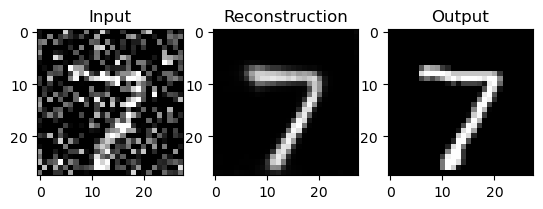

<Figure size 1000x1000 with 0 Axes>

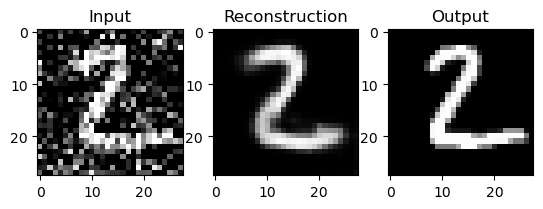

<Figure size 1000x1000 with 0 Axes>

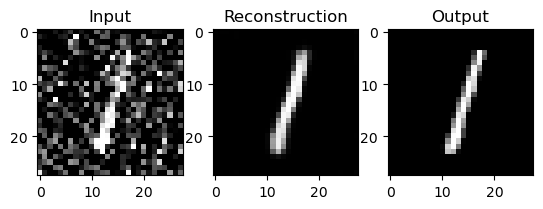

<Figure size 1000x1000 with 0 Axes>

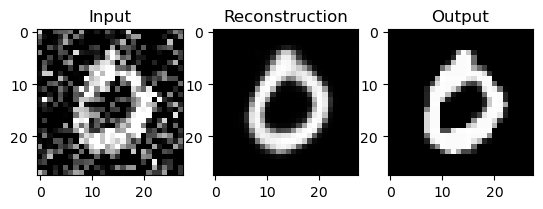

<Figure size 1000x1000 with 0 Axes>

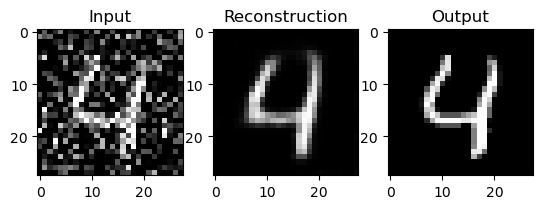

<Figure size 1000x1000 with 0 Axes>

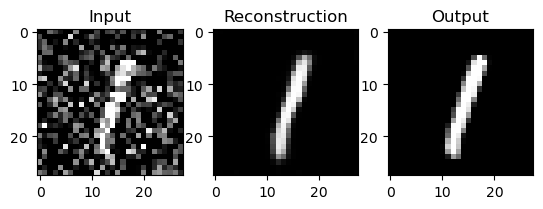

<Figure size 1000x1000 with 0 Axes>

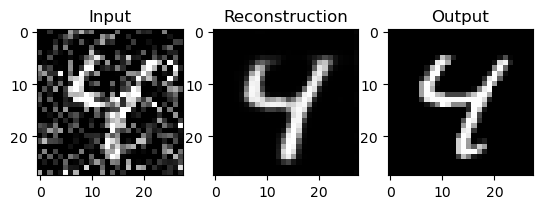

<Figure size 1000x1000 with 0 Axes>

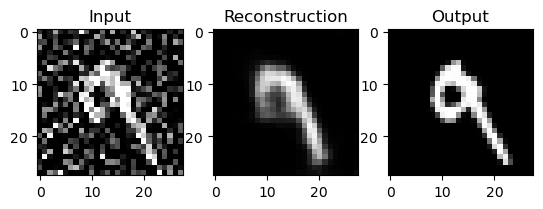

<Figure size 1000x1000 with 0 Axes>

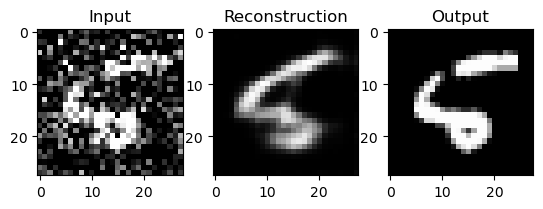

<Figure size 1000x1000 with 0 Axes>

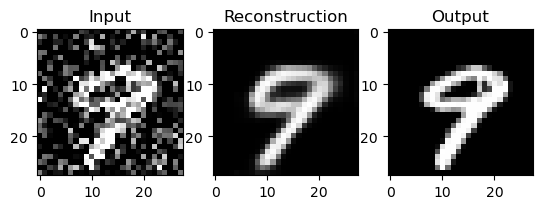

<Figure size 1000x1000 with 0 Axes>

In [26]:
### Plot 10 instances of input, reconstruction and output from the test set

for i in range(10):
    fig, ax = plt.subplots(1, 3)
    fig = plt.figure(figsize=(10,10))
    ax[0].imshow(X[i], cmap='gray')
    ax[1].imshow(recons[i], cmap='gray')
    ax[2].imshow(y[i], cmap='gray')
    ax[0].set_title("Input")
    ax[1].set_title("Reconstruction")
    ax[2].set_title("Output")

